# PyTorch Metric Learning
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install the packages

In [1]:
!pip install pytorch-metric-learning
!pip install -q faiss-gpu
!git clone https://github.com/akamaster/pytorch_resnet_cifar10

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 89.7 MB 49.0 MB/s 
Cloning into 'pytorch_resnet_cifar10'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 91 (delta 1), reused 2 (delta 0), pack-reused 84
Unpacking objects: 100% (91/91), done.


## Import the packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from pytorch_resnet_cifar10 import resnet
from torchvision import datasets, transforms

from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder

## Create helper functions

In [3]:
def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Create the dataset and load the trained model

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)

dataset = datasets.CIFAR10(
    root="CIFAR10_Dataset", train=False, transform=transform, download=True
)
labels_to_indices = c_f.get_labels_to_indices(dataset.targets)
model = torch.nn.DataParallel(resnet.resnet20())
checkpoint = torch.load("pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th")
model.load_state_dict(checkpoint["state_dict"])
model.module.linear = torch.nn.Identity()
model.to(torch.device("cuda"))
print("done model loading")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_Dataset/cifar-10-python.tar.gz to CIFAR10_Dataset
done model loading


## Create the InferenceModel wrapper

In [5]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
inference_model = InferenceModel(model, match_finder=match_finder)

# cars and frogs
classA, classB = labels_to_indices[1], labels_to_indices[6]

## Get nearest neighbors of a query

In [6]:
# create faiss index
inference_model.train_knn(dataset)

query image


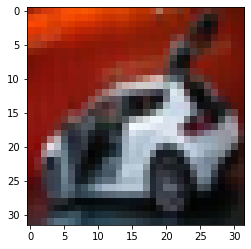

nearest images


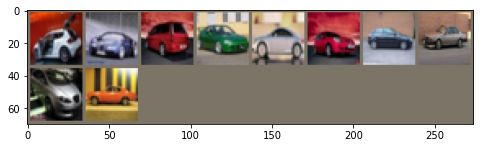

query image


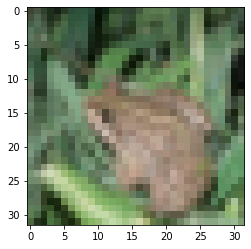

nearest images


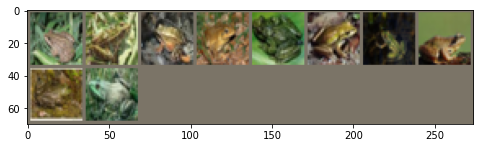

In [7]:
# get 10 nearest neighbors for a car image
for img_type in [classA, classB]:
    img = dataset[img_type[0]][0].unsqueeze(0)
    print("query image")
    imshow(torchvision.utils.make_grid(img))
    distances, indices = inference_model.get_nearest_neighbors(img, k=10)
    nearest_imgs = [dataset[i][0] for i in indices.cpu()[0]]
    print("nearest images")
    imshow(torchvision.utils.make_grid(nearest_imgs))

## Compare two images of the same class

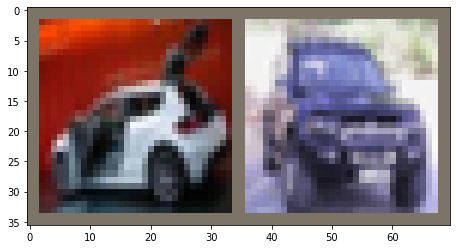

Same class


In [8]:
# compare two images of the same class
(x, _), (y, _) = dataset[classA[0]], dataset[classA[1]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare two images of different classes

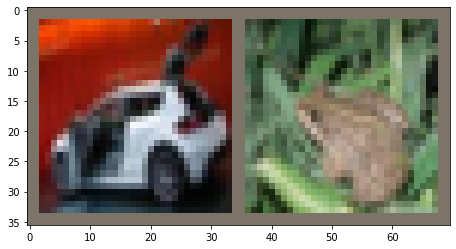

Different class


In [9]:
# compare two images of a different class
(x, _), (y, _) = dataset[classA[0]], dataset[classB[0]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare multiple pairs of images

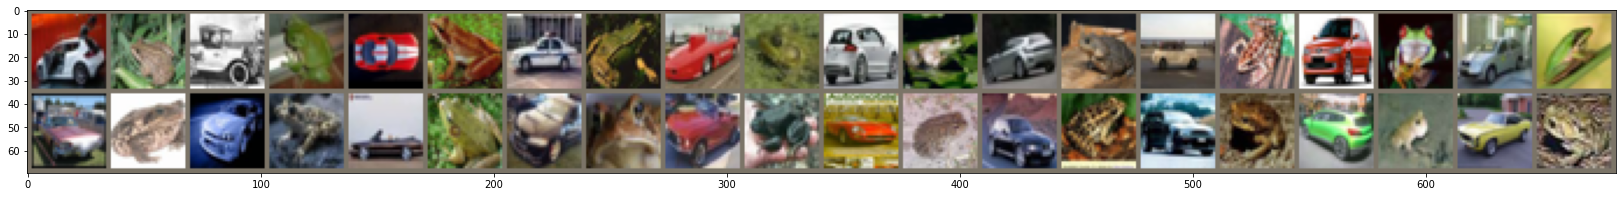

Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
accuracy = 1.0


In [10]:
# compare multiple pairs of images
x = torch.zeros(20, 3, 32, 32)
y = torch.zeros(20, 3, 32, 32)
for i in range(0, 20, 2):
    x[i] = dataset[classA[i]][0]
    x[i + 1] = dataset[classB[i]][0]
    y[i] = dataset[classA[i + 20]][0]
    y[i + 1] = dataset[classB[i + 20]][0]
imshow(torchvision.utils.make_grid(torch.cat((x, y), dim=0), nrow=20), figsize=(30, 3))
decision = inference_model.is_match(x, y)
for d in decision:
    print_decision(d)
print("accuracy = {}".format(np.sum(decision) / len(x)))

## Compare all pairs within a batch

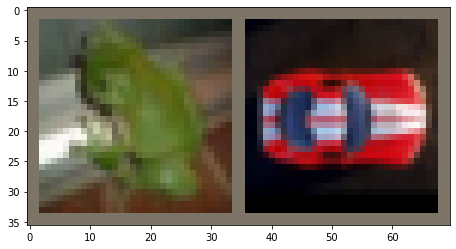

Different class


In [11]:
# compare all pairs within a batch
match_matrix = inference_model.get_matches(x)
assert match_matrix[0, 0]  # the 0th image should match with itself
imshow(torchvision.utils.make_grid(torch.stack((x[3], x[4]), dim=0)))
print_decision(match_matrix[3, 4])  # does the 3rd image match the 4th image?

## Compare all pairs between queries and references

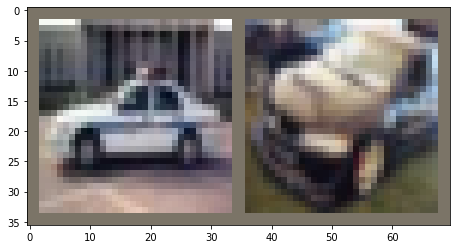

Same class


In [12]:
# compare all pairs between queries and references
match_matrix = inference_model.get_matches(x, y)
imshow(torchvision.utils.make_grid(torch.stack((x[6], y[6]), dim=0)))
print_decision(match_matrix[6, 6])  # does the 6th query match the 6th reference?

# Get results in tuple form

MATCHING IMAGE PAIRS
3 5


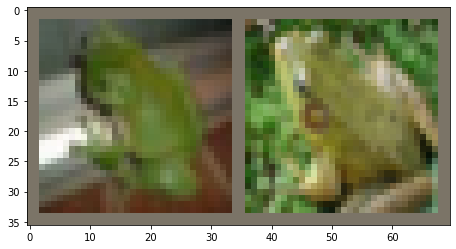

7 3


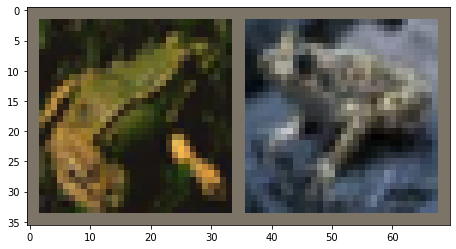

10 12


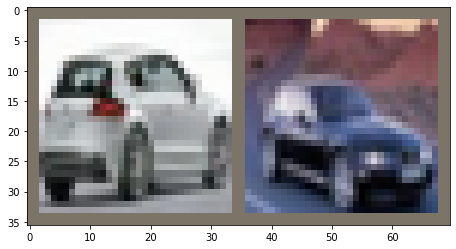

12 14


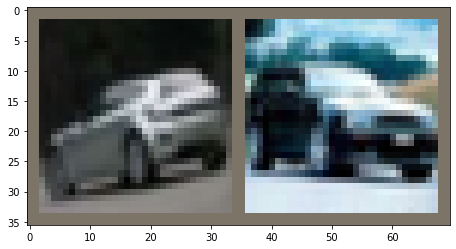

13 3


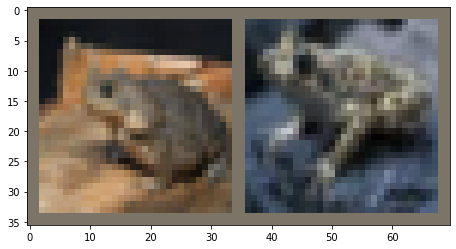

13 5


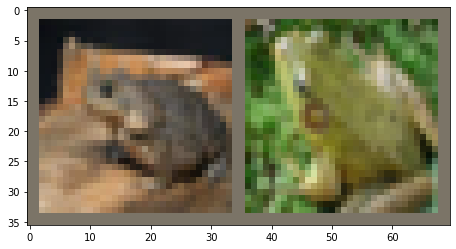

16 18


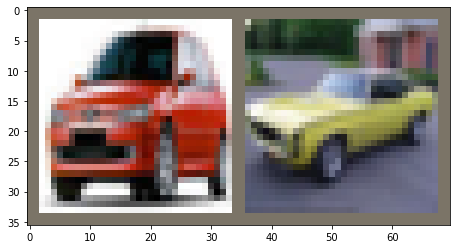

17 3


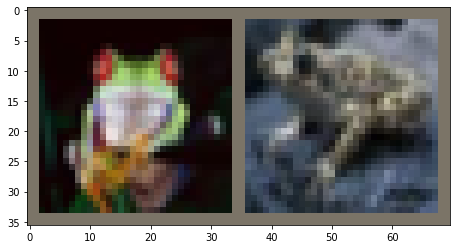

17 5


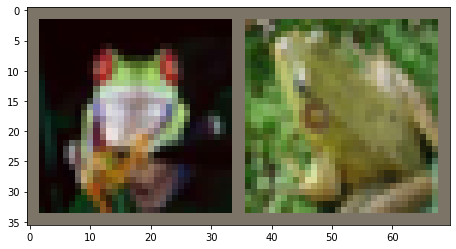

18 8


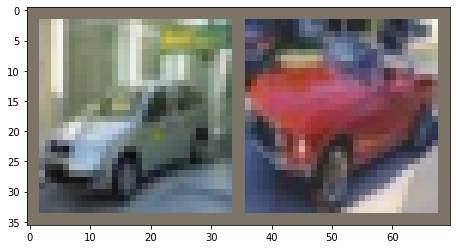

18 10


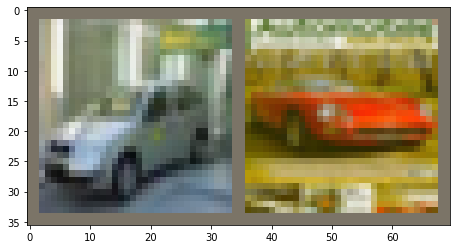

18 18


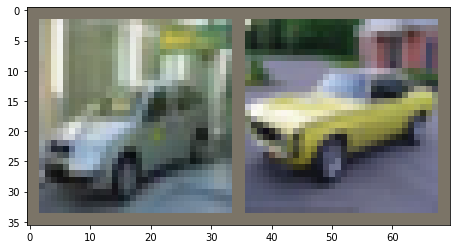

In [13]:
# make a new model with high threshold
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.95)
inference_model = InferenceModel(model, match_finder=match_finder)

# get all matches in tuple form
match_tuples = inference_model.get_matches(x, y, return_tuples=True)
print("MATCHING IMAGE PAIRS")
for i, j in match_tuples:
    print(i, j)
    imshow(torchvision.utils.make_grid(torch.stack((x[i], y[j]), dim=0)))